# Overview of `mobile-env:smart-city` for Smart City Simulation and Digital Twin Synchronization

`mobile-env:smart-city` is an open-source Python environment designed for simulating decentralized Metaverse environments. It provides a flexible and extendable platform for experimenting resource optimization with reinforcement learning (RL) and control algorithms in dynamic environments.

By enabling simulations with moving users, stationary sensors, and flexible configurations, `mobile-env:smart-city` allows the users to model realistic scenarios, assess the efficiency of resource utilization and fine-tune algorithms for real-time synchronization between a digital twin and the actual environment.

## Key Features of `mobile-env:smart-city`

* **Flexibility and Customizability**:
   - `mobile-env:smart-city` is written entirely in Python, making it easy to modify and extend.
   - The environment allows the simulation of a smart city scenario with mobile users (UEs), stationary sensors and a single base station (BS).
   - The number of UEs, sensors, their movement patterns, communication properties and the structure of the network can all be customized to suit a variety of experimental needs.

* **Compatibility with Gymnasium**:
   - `mobile-env:smart-city` adheres to the [Gymnasium](https://gymnasium.farama.org/) (formerly [OpenAI Gym](https://gym.openai.com/)) interface. This ensures compatibility with most reinforcement learning libraries and frameworks, allowing users to experiment with different RL algorithms with minimal integration effort.
   - Using the Gymnasium interface allows easy integration with popular RL libraries such as Stable-Baselines3, RLlib, or custom-built agents.

* **Not Limited to RL**:
   - While the environment is designed with RL in mind, `mobile-env:smart-city` is not restricted to RL algorithms. It can also be used to implement and test conventional control policies or simple rule-based benchmark algorithms. This flexibility enables users to benchmark RL algorithms against traditional approaches.

* **Realistic Network Simulation**:
   - The environment includes realistic simulations of mobile user equipment (UEs), cellular network base stations (BS) and sensors. 
   - UEs move dynamically and their communication quality (e.g., signal-to-noise ratio) changes based on their position relative to the base station. 
   - The scenarios are focused on exploring dynamic resource allocation in cellular networks for smart city applications.

* **Extensibility**:
   - Developers can easily extend the functionality of `mobile-env:smart-city` by modifying or adding custom observation spaces, action spaces or reward functions.
   - It allows simulation of dynamic scenarios, for example, by implementing custom movement patterns for UEs, different scheduling policies for base stations or adding new types of observations and rewards based on the needs of the experiment.

## Use Case for `mobile-env:smart-city`

This environment provides a platform for testing and evaluating resource allocation strategies, network control algorithms and Metaverse-related optimizations in a smart city environment. Reinforcement learning agents can be trained and evaluated in the environment to dynamically manage resources such as bandwidth and computational power for multiple devices and sensors. 

Its flexibility, ease of use and compatibility with Gymnasium make it an ideal tool for working on smart city or decentralized Metaverse applications.

## Customized gymnasium environment: `mobile-env:smart-city`

**Demonstration Steps:**

This demonstration consists of the following steps:

1. Installation and usage of `mobile-env:smart-city` with dummy actions
2. Configuration of `mobile-env:smart-city` and adjustment of the observation space

In additional notebooks within this project, you will find implementations of both a baseline scenario and a reinforcement learning (RL) approach for comparison. 

- The **baseline scenario** employs fixed policy splits and conventional control methods to allocate resources, providing a straightforward comparison point for evaluating the benefits of RL. 
- The **RL approach**, on the other hand, uses dynamic decision-making to optimize resource allocation in response to changing network conditions. 

By examining these two approaches side by side, we can assess the effectiveness and adaptability of RL algorithms over traditional static policies, providing insights into their potential for complex, dynamic environments like smart cities.

### Step 1: Installation and usage of `mobile-env:smart-city`

#### Importing necessary libraries:

- `gymnasium` is the core framework for creating and using custom environments
- `mobile_env` is the custom environment that we're demonstrating
- `matplotlib` is used for visualizing the environment's state

In [1]:
# Step 1: Import necessary libraries

import gymnasium as gym

# importing mobile_env automatically registers the predefined scenarios in Gym
import mobile_env

import matplotlib.pyplot as plt

In [2]:
# predefined smart city scenario
from mobile_env.scenarios.smart_city import MComSmartCity

# easy access to the default smart city configuration, parameters and settings
MComSmartCity.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 666,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.RoundRobin,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.smart_city_handler.MComSmartCityHandler,
 'bs': {'bw': 100000000.0,
  'freq': 2500,
  'tx': 40,
  'height': 50,
  'computational_power': 100},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'sensor': {'height': 1.5,
  'snr_tr': 2e-08,
  'noise': 1e-09,
  'velocity': 0,
  'radius': 500,
  'logs': {}},
 'ue_job': {'job_generation_probability': 0.7,
  'communication_job_lambda_value': 2.875,
  'computation_job_lambda_value': 10.0},
 'sensor_job': {'communication_job_lambda_value': 1.125,
  'computation_job_lambda_value': 5.0},
 'e2e_delay_threshold': 5,
 'reward_calculati

#### Environment Registration

In Gymnasium, registering a new environment is essential when defining a custom environment that can be accessed easily and used with various reinforcement learning frameworks.

In [3]:
from gymnasium.envs.registration import register

# Register the new environment
register(
    id='mobile-smart_city-smart_city_handler-v0',
    entry_point='mobile_env.scenarios.smart_city:MComSmartCity',
    kwargs={'config': {}, 'render_mode': None}
)

/home/elifohri/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment mobile-smart_city-smart_city_handler-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [4]:
# List all registered environments
env_specs = gym.envs.registry.keys()
print(f"Env specs: {env_specs}")

# Verify if specific environment is listed
assert 'mobile-smart_city-smart_city_handler-v0' in env_specs, "Environment not registered correctly"
print("Environment 'mobile-smart_city-smart_city_handler-v0' registered successfully!")

Env specs: dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'mobile-smart_city-smart_city_handler-v0'])
Environment 'mobile-smart_city-smart_city_handler-v0' reg

### Step 2: Extending `mobile-env:smart-city` and tracking custom metrics

`mobile-env:smart-city` allows to define and track custom metrics during the training and testing phases in reinforcement learning (RL). This is essential for evaluating and understanding how well RL agents and different baseline policies perform in a decentralized smart city scenario.

It defines an interface for metrics that record values per user equipment and per sensor (e.g. utility per device), basestation (e.g. number of connections per station) or time step (e.g. average utility of device).

**The following key performance indicators (KPIs) are monitored:**

- **Number of connections:** Tracks the total number of active user and sensor connections in the network.
- **Utility metrics:** Measures the utility of user equipments (UEs) and sensors in terms of network performance.
- **Distance to base stations:** Monitors how far UEs and sensors are from the base station, which is essential to understand their connectivity strength.
- **Signal-to-Noise Ratio (SNR):** Measures the quality of the connection between UEs/sensors and base stations.
- **Throughput:** Calculates the data transfer rate for UEs and sensors, as well as for the base station.
- **Bandwidth and computational resource utilization:** Monitors how much of the available bandwidth and computational power is being used by UEs and sensors.

Later, we load the monitored metrics as `pandas` data frames.

In [5]:
import numpy as np

# overall number of active connections for UEs
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])

# overall number of active connections for sensors
def overall_connections_sensor(sim):
    return sum(len(conns) for conns in sim.connections_sensor.values())


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}

# monitors utility per sensor
def user_utility_sensor(sim):
    return {sensor.sensor_id: utility for sensor, utility in sim.utilities_sensor.items()}


# monitors each user equipment's distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestation
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector


    distances = {}    
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2))
        
        distances[ue_id] = dist
    
    return distances

# monitors each sensor's distance to their closest base station
def sensor_closest_distance(sim):
    # position vector of basestations
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector

    distances = {}    
    for sensor_id, sensor in sim.sensors.items():
        spos = np.array([[sensor.x, sensor.y]])
        dist = np.sqrt(np.sum((bpos - spos)**2))
        
        distances[sensor_id] = dist
    
    return distances


# number of UE connections per basestation
def station_connections_ue(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}

# number of sensor connections per basestation
def station_connections_sensor(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections_sensor.items()}

Throughput is a key metric that measures the amount of data transferred successfully over the network.

In [6]:
# add throughput metrics

def calculate_throughput_bs(sim):
    """Calculate throughput for all base stations in the environment."""
    throughput_bs = {}

    for bs in sim.stations.values():
        # Sum data rates for all UEs connected to the base station
        ue_throughput = sum(sim.datarates[(bs, ue)] for ue in sim.connections[bs])

        # Sum data rates for all sensors connected to the base station
        sensor_throughput = sum(sim.datarates_sensor[(bs, sensor)] for sensor in sim.connections_sensor[bs])

        # Total throughput for the base station
        total_throughput = ue_throughput + sensor_throughput

        # Store the throughput value for this base station
        throughput_bs[bs.bs_id] = total_throughput

    return throughput_bs

def calculate_throughput_ue(sim):
    """Calculate the throughput for UEs in the environment."""
    
    # Initialize dictionary to store throughput for each UE
    ue_throughput = {}

    # Calculate throughput for UEs
    for ue in sim.users.values():
        # Get the total data rate for this UE
        total_data_rate_ue = sum(sim.datarates[(bs, ue)] for bs in sim.stations.values() if (bs, ue) in sim.datarates)
        
        # Assume time window of 1 second for throughput calculation
        ue_throughput[ue.ue_id] = total_data_rate_ue * 1  # Throughput in Mbps

    return ue_throughput


def calculate_throughput_sensor(sim):
    """Calculate the throughput for sensors in the environment."""
    
    # Initialize dictionaries to store throughput for each sensor
    sensor_throughput = {}

    # Calculate throughput for sensors
    for sensor in sim.sensors.values():
        # Get the total data rate for this sensor
        total_data_rate_sensor = sum(sim.datarates_sensor[(bs, sensor)] for bs in sim.stations.values() if (bs, sensor) in sim.datarates_sensor)
        
        # Assume time window of 1 second for throughput calculation
        sensor_throughput[sensor.sensor_id] = total_data_rate_sensor * 1  # Throughput in Mbps
        
    return sensor_throughput

SNR is a key metric for measuring the quality of the signal between UEs/sensors and base stations.

In [7]:
# add snr values as metrics

def calculate_snr_ue(sim):
    """Calculate the SNR for UEs in the environment."""
    
    snr_ue = {}
    
    # Loop over all UEs to calculate SNR
    for ue in sim.users.values():
        # Find the base station connected to the UE
        for bs in sim.stations.values():
            if ue in sim.connections[bs]:
                # Use the channel object to calculate the SNR between BS and UE
                snr_value = sim.channel.snr(bs, ue)
                snr_ue[ue.ue_id] = snr_value
                break

    return snr_ue

def calculate_snr_sensor(sim):
    """Calculate the SNR for sensors in the environment."""
    
    snr_sensor = {}
    
    # Loop over all sensors to calculate SNR
    for sensor in sim.sensors.values():
        # Find the base station connected to the sensor
        for bs in sim.stations.values():
            if sensor in sim.connections_sensor[bs]:
                # Use the channel object to calculate the SNR between BS and sensor
                snr_value = sim.channel.snr(bs, sensor)
                snr_sensor[sensor.sensor_id] = snr_value
                break

    return snr_sensor

In [8]:
 # Calculate bandwidth utilization and computational power utilization
    
def bandwidth_utilization_ue(sim):
    """Calculate the bandwidth utilization of ues for each base station."""
    
    bw_utilization = {}

    # Iterate over all base stations
    for bs in sim.stations.values():
        allocated_bw_ue = sim.resource_allocations[bs]['bandwidth_for_ues']
        bw_utilization[bs.bs_id] = allocated_bw_ue

    return bw_utilization

def bandwidth_utilization_sensor(sim):
    """Calculate the bandwidth utilization of sensors for each base station."""
    
    bw_utilization = {}

    # Iterate over all base stations
    for bs in sim.stations.values():
        allocated_bw_sensor = sim.resource_allocations[bs]['bandwidth_for_sensors']
        bw_utilization[bs.bs_id] = allocated_bw_sensor

    return bw_utilization


def computational_power_utilization_ue(sim):
    """Calculate the computational power utilization of ues for each base station."""
    
    cpu_utilization = {}

    for bs in sim.stations.values():
        allocated_cpu_ue = sim.resource_allocations[bs]['computational_power_for_ues']
        cpu_utilization[bs.bs_id] = allocated_cpu_ue

    return cpu_utilization

def computational_power_utilization_sensor(sim):
    """Calculate the computational power utilization of sensors for each base station."""
    
    cpu_utilization = {}

    for bs in sim.stations.values():
        allocated_cpu_sensor = sim.resource_allocations[bs]['computational_power_for_sensors']
        cpu_utilization[bs.bs_id] = allocated_cpu_sensor

    return cpu_utilization


All custom metrics are registered in the configuration for the mobile-env environment.

In [9]:
# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall connections": overall_connections, "overall connections sensors": overall_connections_sensor},
            "ue_metrics": {"distance station": user_closest_distance, "user utility": user_utility, "user throughput": calculate_throughput_ue, "user snr": calculate_snr_ue },
            "bs_metrics": {"station connections UE": station_connections_ue,"station connections sensors": station_connections_sensor, "station throughput": calculate_throughput_bs, "bw utilization for users": bandwidth_utilization_ue, "bw utilization for sensors": bandwidth_utilization_sensor, "comp power utilization ue": computational_power_utilization_ue, "comp power utilization sensor": computational_power_utilization_sensor},
            "ss_metrics": {"distance station sensors": sensor_closest_distance, "sensor utility": user_utility_sensor, "sensor throughput": calculate_throughput_sensor, "sensor snr": calculate_snr_sensor}
            }
         }

#### Environment Creation

Create the simulation environment using the `make()` function, which instantiates the "smart-city" scenario with the configuration specified by the config parameter.

In [10]:
# create a small mobile environment for a single, centralized control agent
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gym.make("mobile-smart_city-smart_city_handler-v0", config=config, render_mode="rgb_array")

print(f"\nSmart city environment with {env.NUM_USERS} users, {env.NUM_SENSORS} sensors and {env.NUM_STATIONS} cells.")


Smart city environment with 5 users, 20 sensors and 1 cells.


#### Environment Data

In [11]:
obs, info = env.reset()
print("obs:", obs)
print("info:", info)

print("\nMetadata")
print("metadata:", env.metadata)

print("\nRender Modes")
print("render modes:", env.render_mode)

print("\nSpec:")
print("spec:", env.spec)

print("\nAction Space")
print("action space:", env.action_space)
print("action space shape:", env.action_space.shape)
print("simple action:", env.action_space.sample())

print("\nObservation Space")
print("observation space:", env.observation_space)
print("observation space shape:", env.observation_space.shape)
print("sample observation:", env.observation_space.sample())

print("\nReward Range")
print("reward range:", env.reward_range)


obs: [0. 0. 0. 0. 0. 0.]
info: {}

Metadata
metadata: {'render_modes': ['rgb_array', 'human']}

Render Modes
render modes: rgb_array

Spec:
spec: EnvSpec(id='mobile-smart_city-smart_city_handler-v0', entry_point='mobile_env.scenarios.smart_city:MComSmartCity', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'config': {'metrics': {'scalar_metrics': {'overall connections': <function overall_connections at 0x7bc90671a7a0>, 'overall connections sensors': <function overall_connections_sensor at 0x7bc90671a830>}, 'ue_metrics': {'distance station': <function user_closest_distance at 0x7bc90671ac20>, 'user utility': <function user_utility at 0x7bc90671ab00>, 'user throughput': <function calculate_throughput_ue at 0x7bc90671aef0>, 'user snr': <function calculate_snr_ue at 0x7bc952748dc0>}, 'bs_metrics': {'station connections UE': <function station_connections_ue at 0x7bc

In [12]:
# Debug: Check what `env.render()` is returning
print(type(env.render()), env.render().shape if isinstance(env.render(), np.ndarray) else "Not an array")


/home/elifohri/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


<class 'numpy.ndarray'> (500, 800, 3)


### Step 3: Demo with Dummy Actions

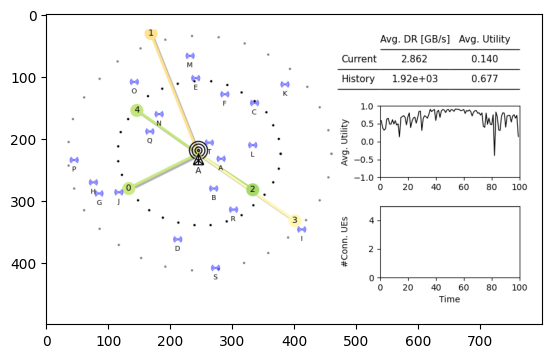

In [13]:
from IPython import display

# run the simulation for 20 time steps
done = False
obs, info = env.reset()

total_episode_reward = 0
total_reward_over_time = []  # List to store the reward at each time step

for _ in range(100):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)
    
    # accumulate total reward for the episode
    total_episode_reward += reward
    total_reward_over_time.append(total_episode_reward) 

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    
plt.close()

In [14]:
total_reward_over_time

[40.0,
 67.0,
 107.5,
 114.79,
 137.47,
 173.272,
 196.89159999999998,
 223.46364999999997,
 239.40687999999997,
 239.40687999999997,
 239.40687999999997,
 239.40687999999997,
 281.60139999999996,
 307.701058,
 317.798437,
 336.9834571,
 345.5928013,
 370.55989948,
 384.894457573,
 388.03256353390003,
 407.55855617950004,
 419.1695482348301,
 422.3076541957301,
 435.5818424103371,
 446.34554585622413,
 451.45752046653024,
 456.0328789575224,
 468.26207788714976,
 476.9806776783182,
 476.9806776783182,
 492.1047793568758,
 502.8522964522165,
 502.8522964522165,
 506.55833682992017,
 508.411357018772,
 515.6587248685037,
 517.5117450573555,
 528.5538923627236,
 531.5557850686636,
 539.5408196664639,
 542.8233893404092,
 546.1059590143545,
 550.1544616122205,
 550.1544616122205,
 552.3428413948508,
 553.3276122970344,
 558.4779641154547,
 561.0623968711454,
 563.216090834221,
 565.8005235899117,
 568.3849563456024,
 571.2924431957545,
 572.4554379358152,
 574.0836305719004,
 574.606978204

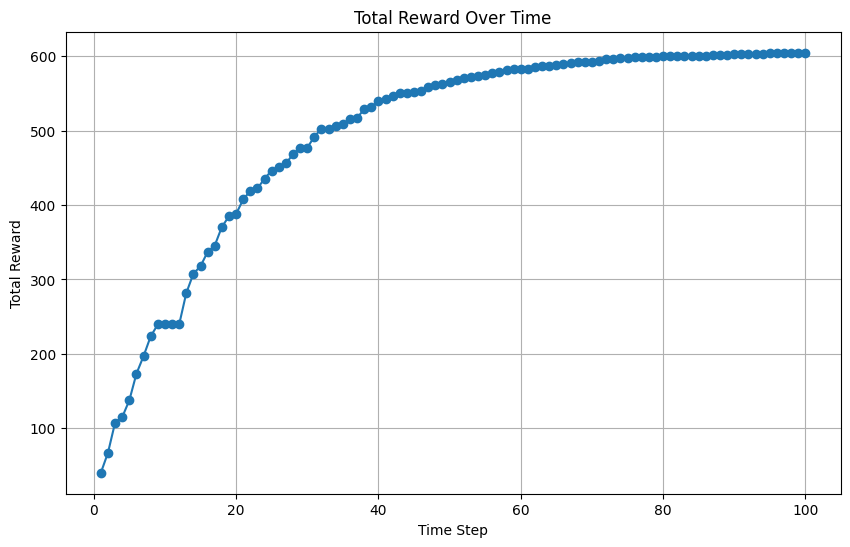

In [15]:
# Plot the reward over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward_over_time) + 1), total_reward_over_time, marker='o')
plt.title('Total Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

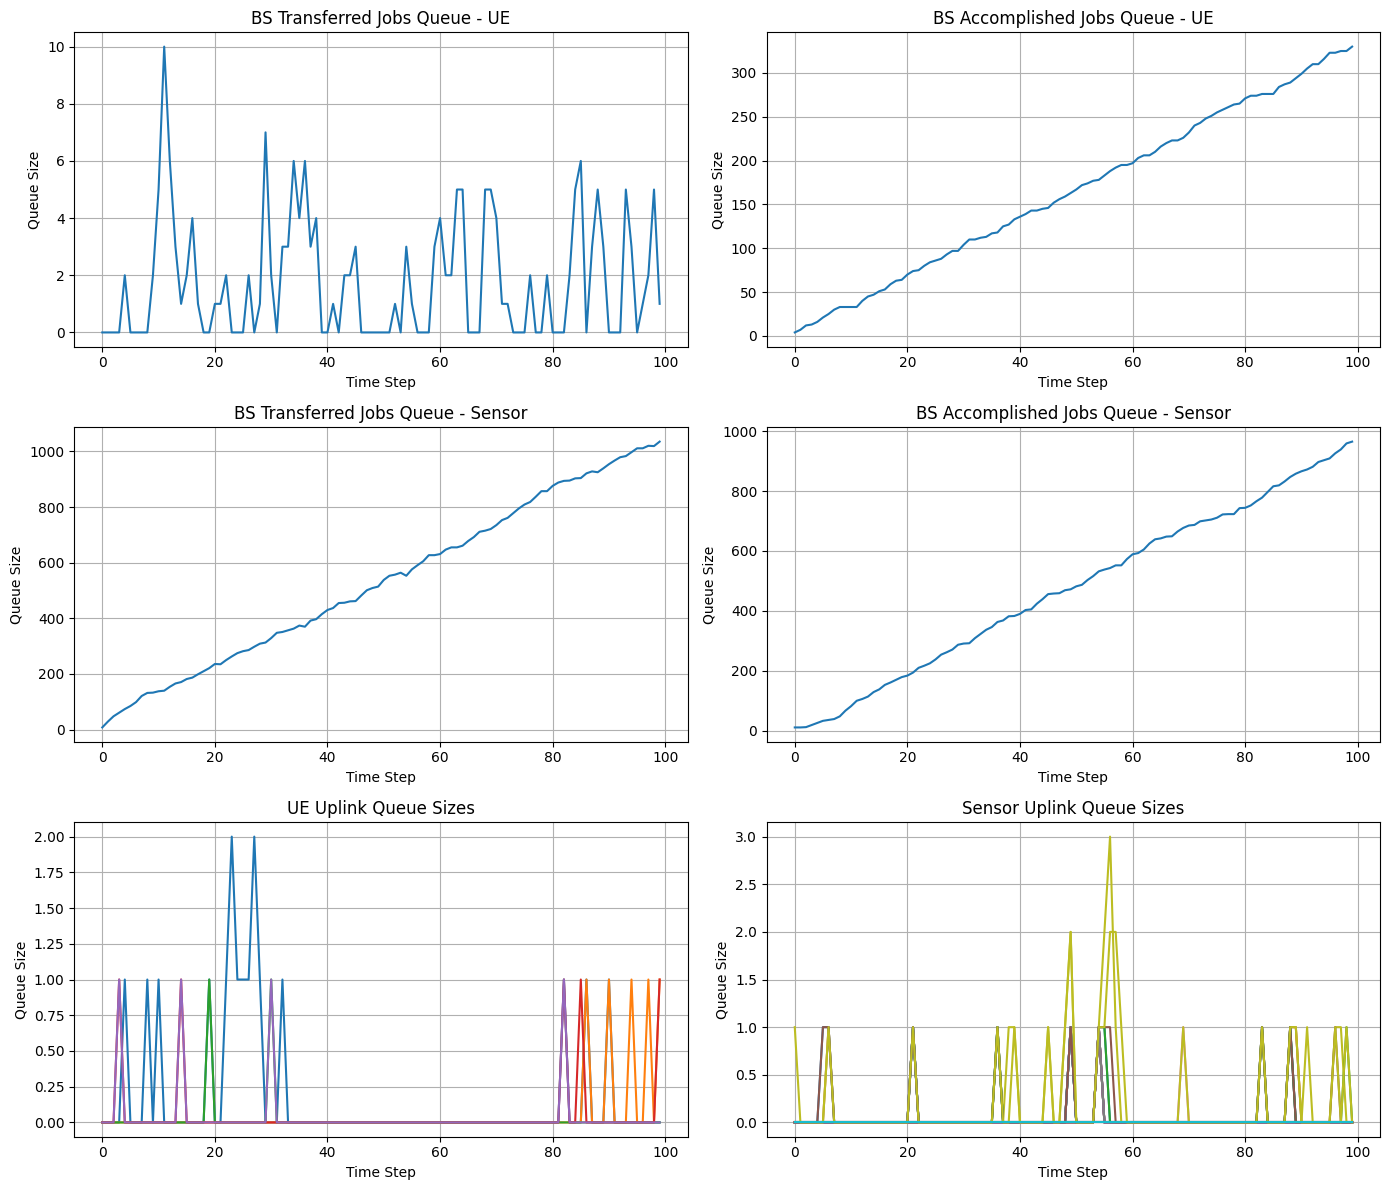

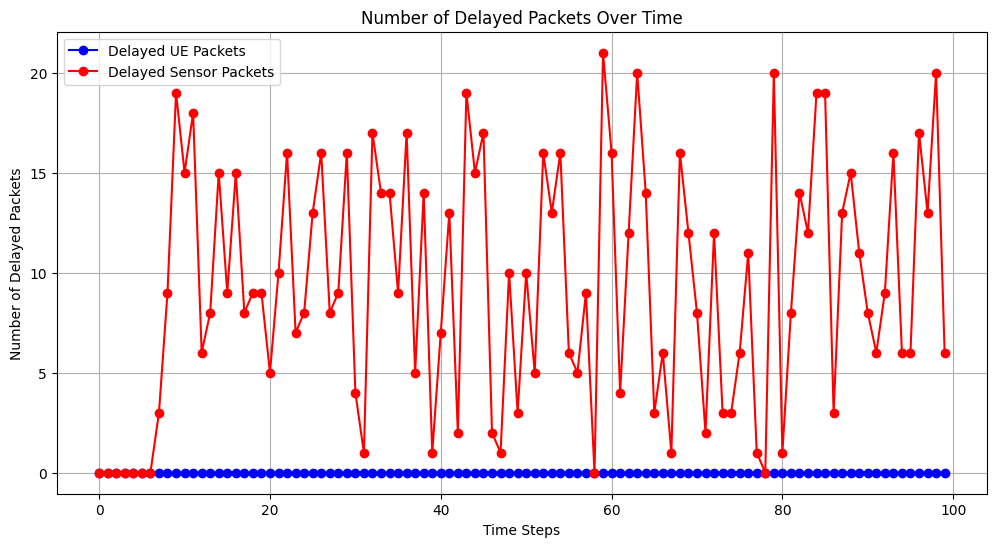

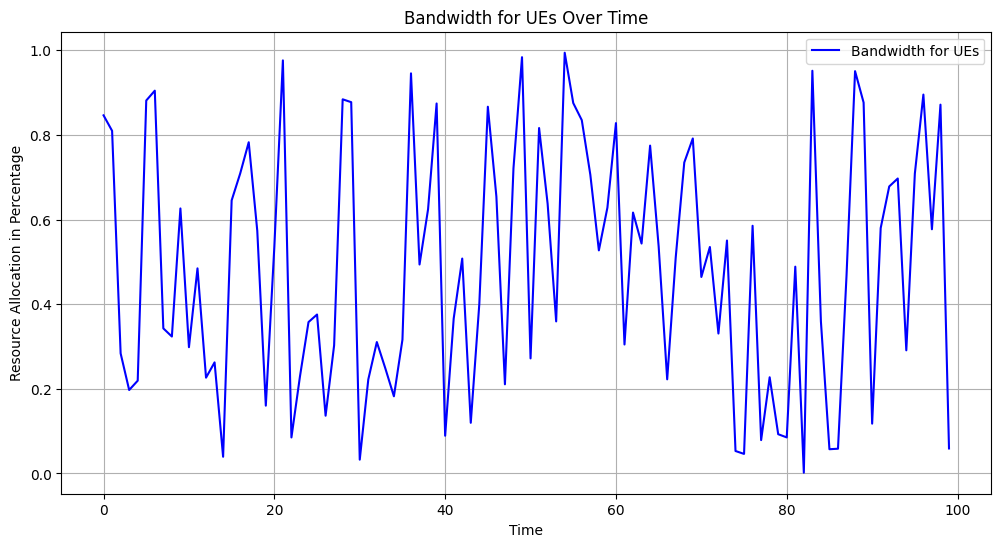

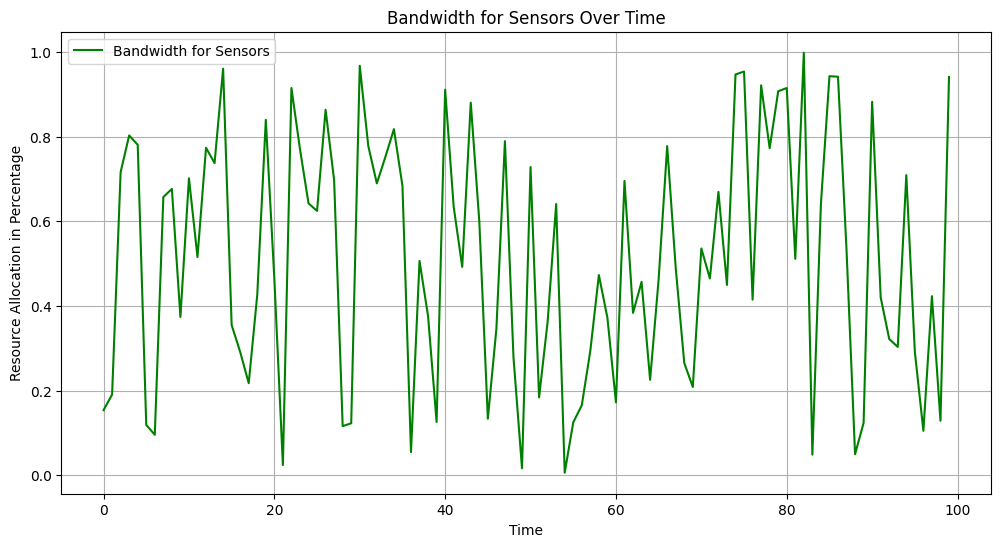

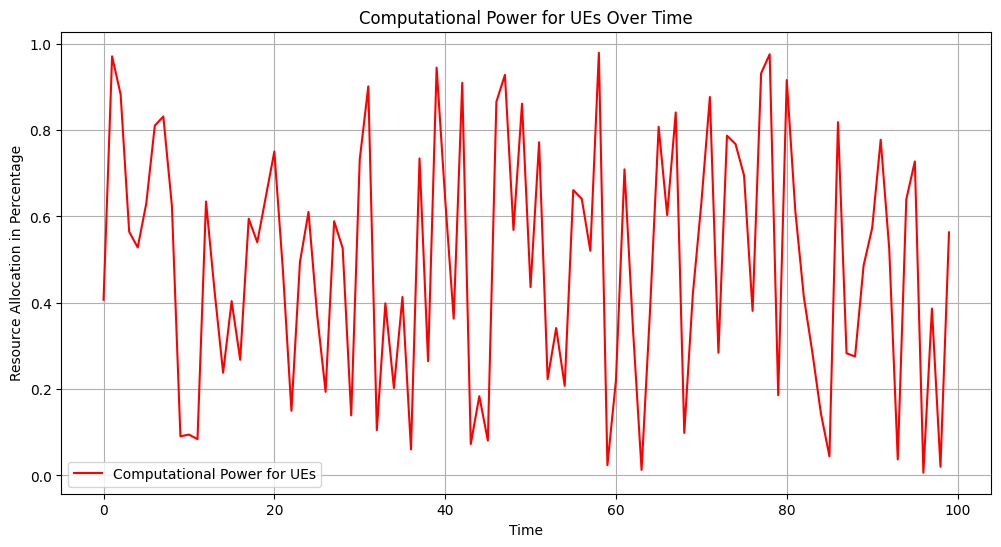

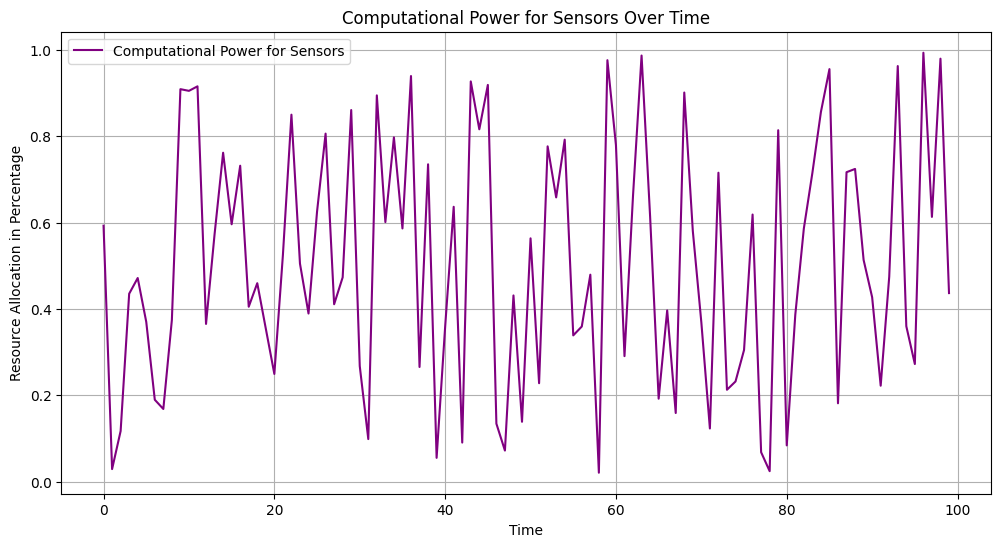

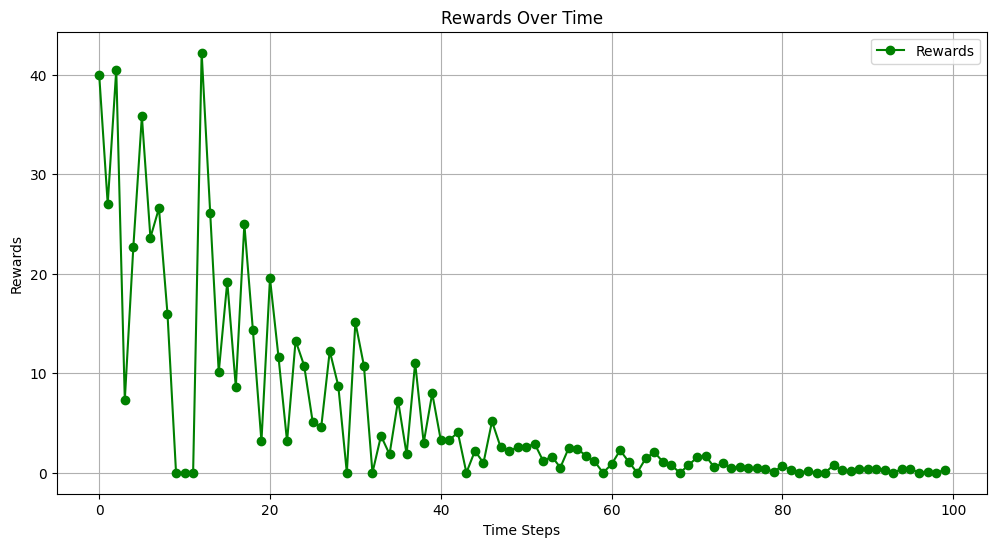

In [ ]:
# Plot other environment metrics
env.plot_queue_sizes()
env.plot_delayed_packets()
env.plot_resource_allocations()
env.plot_rewards()

In [ ]:
env.plot_throughput()
env.plot_cumulative_throughput()

In [ ]:
env.plot_aoi_per_device()

In [17]:

# load all tracked results as pandas data frames
scalar_results, ue_results, bs_results, ss_results = env.monitor.load_results()

# show general results
scalar_results.head()

,overall connections,overall connections sensors,number connections,number connections sensor,number connected,number connected sensor,mean utility,mean utility sensor,mean datarate,mean datarate sensor
Time Step,,,,,,,,,,
0,5,20,5,20,5,20,0.587355,0.457520,31.909852,119.138997
1,5,20,5,20,5,20,0.588312,0.499221,33.724955,147.475880
2,5,20,5,20,5,20,0.381197,0.737788,12.487356,555.131639
3,5,20,5,20,5,20,0.319094,0.755119,10.083557,622.175234
4,5,20,5,20,5,20,0.356256,0.750887,12.542631,605.089961


In [18]:
ue_results

Metric           distance station      user snr  user throughput  user utility
Time Step UE ID                                                               
0         0             99.946785  5.522235e-08         6.742136      0.414399
          1             43.472946  9.734075e-07       118.843955      1.000000
          2            101.735100  5.354209e-08         6.536991      0.407689
          3             75.488173  1.475166e-07        18.010405      0.627762
          4             92.039596  7.712114e-08         9.415775      0.486928
...                           ...           ...              ...           ...
99        0             56.554186  3.812700e-07         3.247030      0.255743
          1            104.867118  4.974990e-08         0.423688     -0.186477
          2             47.216607  7.182900e-07         6.117211      0.393277
          3             86.227001  9.391788e-08         0.799838     -0.048499
          4             54.824342  4.373387e-07         3.724532      0.285536

[500 rows x 4 columns]

In [19]:
ss_results

Metric               distance station sensors    sensor snr  \
Time Step Sensor ID                                           
0         0                         16.492423  2.503599e-05   
          1                         30.083218  3.288423e-06   
          2                         57.280014  3.736486e-07   
          3                         70.611614  1.843187e-07   
          4                         61.032778  3.015702e-07   
...                                       ...           ...   
99        15                        89.140339  8.390842e-08   
          16                        39.357337  1.326987e-06   
          17                        51.478151  5.359168e-07   
          18                        92.779308  7.330285e-08   
          19                        12.041595  7.242497e-05   

Metric               sensor throughput  sensor utility  
Time Step Sensor ID                                     
0         0                 555.260945        1.000000  
          1                  72.933109        0.931462  
          2                   8.287072        0.459201  
          3                   4.087964        0.305754  
          4                   6.688460        0.412663  
...                                ...             ...  
99        15                 11.390831        0.528278  
          16                180.142497        1.000000  
          17                 72.752370        0.930924  
          18                  9.951093        0.498935  
          19               9831.561850        1.000000  

[2000 rows x 4 columns]

In [20]:
bs_results

,Metric,bw utilization for sensors,bw utilization for users,comp power utilization sensor,comp power utilization ue,station connections UE,station connections sensors,station throughput
Time Step,BS ID,,,,,,,
0,0,1.537316e+07,8.462684e+07,59.292382,40.707618,5.0,20.0,2542.329210
1,0,1.902963e+07,8.097037e+07,2.913105,97.086895,5.0,20.0,3118.142369
2,0,7.163171e+07,2.836829e+07,11.730605,88.269395,5.0,20.0,11165.069563
3,0,8.028271e+07,1.971729e+07,43.529737,56.470263,5.0,20.0,12493.922469
4,0,7.807811e+07,2.192189e+07,47.171116,52.828884,5.0,20.0,12164.512369
...,...,...,...,...,...,...,...,...
95,0,2.914928e+07,7.085072e+07,27.250504,72.749496,5.0,20.0,4753.255519
96,0,1.046504e+07,8.953496e+07,99.358457,0.641543,5.0,20.0,1889.252063
97,0,4.229566e+07,5.770434e+07,61.330438,38.669562,5.0,20.0,6717.138803


In [21]:
data = ue_results.reset_index()
data = data.groupby('UE ID').agg(['mean', 'min', 'max'])
data = data.drop('Time Step', axis='columns')
data.head()

Metric distance station                             user snr                \
                   mean        min         max          mean           min   
UE ID                                                                        
0             81.330213  56.554186   99.946785  1.450195e-07  5.522235e-08   
1             47.964568  13.257969  106.225573  9.470140e-06  4.773798e-08   
2             43.210365   5.406402  101.735100  1.098636e-04  5.354209e-08   
3             51.769772  31.935622   86.227001  1.031490e-06  9.391788e-08   
4             46.767755  26.218494   92.039596  1.910709e-06  7.712114e-08   

Metric               user throughput                          user utility  \
                 max            mean       min            max         mean   
UE ID                                                                        
0       3.812700e-07       10.048648  0.065889      47.845446     0.390377   
1       6.917229e-05      578.430720  0.026822    8755.771753     0.744195   
2       2.454199e-03     8769.129225  0.650497  259860.310672     0.766463   
3       3.008287e-06       77.926325  0.065443     404.490735     0.718259   
4       6.144116e-06      146.790347  0.463746     747.551506     0.765157   

Metric                     
             min      max  
UE ID                      
0      -0.590594  0.83992  
1      -0.785758  1.00000  
2      -0.093377  1.00000  
3      -0.592069  1.00000  
4      -0.166860  1.00000

In [22]:
data = ss_results.reset_index()
data = data.groupby('Sensor ID').agg(['mean', 'min', 'max'])
data = data.drop('Time Step', axis='columns')
data.head()

Metric    distance station sensors                          sensor snr  \
                              mean        min        max          mean   
Sensor ID                                                                
0                        16.492423  16.492423  16.492423  2.503599e-05   
1                        30.083218  30.083218  30.083218  3.288423e-06   
2                        57.280014  57.280014  57.280014  3.736486e-07   
3                        70.611614  70.611614  70.611614  1.843187e-07   
4                        61.032778  61.032778  61.032778  3.015702e-07   

Metric                                sensor throughput             \
                    min           max              mean        min   
Sensor ID                                                            
0          2.503599e-05  2.503599e-05       1849.440675  20.717315   
1          3.288423e-06  3.288423e-06        242.922648   2.721204   
2          3.736486e-07  3.736486e-07         27.602245   0.309199   
3          1.843187e-07  1.843187e-07         13.616026   0.152526   
4          3.015702e-07  3.015702e-07         22.277651   0.249553   

Metric                 sensor utility                      
                   max           mean       min       max  
Sensor ID                                                  
0          3605.793417       0.995106  0.658167  1.000000  
1           473.618265       0.957933  0.217381  1.000000  
2            53.815185       0.657275 -0.254881  0.865452  
3            26.546717       0.503828 -0.408328  0.712005  
4            43.434001       0.610737 -0.301419  0.818915